In [ ]:
try:
    import missingno as msno
    print("✓ missingno is already installed")
except ImportError:
    import subprocess
    import sys
    print("Installing missingno package...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "missingno", "--quiet"])
    import missingno as msno
    print("✓ missingno installed successfully")


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu

sns.set_theme(style="whitegrid")

df = pd.read_csv("train_u6lujuX_CVtuZ9i.csv")
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Data Cleaning and Preprocessing

This section performs comprehensive data cleaning to ensure data quality before exploratory analysis.


In [ ]:
# ============================================================================
# STEP 1: DATA QUALITY ASSESSMENT
# ============================================================================
print("STEP 1: INITIAL DATA QUALITY ASSESSMENT")
print("=" * 70)

# Create a copy for cleaning
df_original = df.copy()
df_clean = df.copy()

print(f"Dataset Shape: {df_clean.shape}")
print(f"Duplicate Rows: {df_clean.drop('Loan_ID', axis=1).duplicated().sum()}")
print(f"Duplicate Loan_IDs: {df_clean['Loan_ID'].duplicated().sum()}")


STEP 1: INITIAL DATA QUALITY ASSESSMENT

Original Dataset Shape: (614, 13)
Original Memory Usage: 316.62 KB

Duplicate Rows (excluding Loan_ID): 0
Duplicate Loan_IDs: 0

CATEGORICAL VALUES CHECK

Gender:
  Unique values: ['Female', 'Male']
  Value counts:
Gender
Male      489
Female    112
Name: count, dtype: int64

Married:
  Unique values: ['No', 'Yes']
  Value counts:
Married
Yes    398
No     213
Name: count, dtype: int64

Dependents:
  Unique values: ['0', '1', '2', '3+']
  Value counts:
Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64

Education:
  Unique values: ['Graduate', 'Not Graduate']
  Value counts:
Education
Graduate        480
Not Graduate    134
Name: count, dtype: int64

Self_Employed:
  Unique values: ['No', 'Yes']
  Value counts:
Self_Employed
No     500
Yes     82
Name: count, dtype: int64

Credit_History:
  Unique values: [np.float64(0.0), np.float64(1.0)]
  Value counts:
Credit_History
1.0    475
0.0     89
Name: count, dtype: int64

P

In [ ]:
# ============================================================================
# STEP 2: HANDLE INCONSISTENT VALUES
# ============================================================================
print("\nSTEP 2: HANDLING INCONSISTENT VALUES")
print("=" * 70)

# Fix Dependents: Standardize "3+" to "3" for consistency
if 'Dependents' in df_clean.columns:
    df_clean['Dependents'] = df_clean['Dependents'].replace('3+', '3')

# Standardize categorical values (remove extra spaces)
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].str.strip() if df_clean[col].dtype == 'object' else df_clean[col]

# Convert Credit_History to int
if 'Credit_History' in df_clean.columns:
    df_clean['Credit_History'] = df_clean['Credit_History'].apply(
        lambda x: int(x) if pd.notna(x) else x
    )

# Convert Loan_Amount_Term to int
if 'Loan_Amount_Term' in df_clean.columns:
    df_clean['Loan_Amount_Term'] = df_clean['Loan_Amount_Term'].apply(
        lambda x: int(x) if pd.notna(x) else x
    )

print("✓ Inconsistent values handled")


STEP 2: HANDLING INCONSISTENT VALUES

Standardizing Dependents column...
Before: Dependents
0     345
1     102
2     101
3+     51
Name: count, dtype: int64
After: Dependents
0    345
1    102
2    101
3     51
Name: count, dtype: int64

Standardizing categorical values...

Converting Credit_History to categorical...
Before dtype: float64
Unique values: [np.float64(0.0), np.float64(1.0)]
After dtype: float64

Converting Loan_Amount_Term to integer...

✓ Inconsistent values handled


STEP 3: MISSING VALUE ANALYSIS

Missing Values Summary:
                  Missing_Count  Missing_Percentage
Credit_History               50            8.143322
Self_Employed                32            5.211726
LoanAmount                   22            3.583062
Dependents                   15            2.442997
Loan_Amount_Term             14            2.280130
Gender                       13            2.117264
Married                       3            0.488599

----------------------------------------------------------------------
MISSING VALUE PATTERNS BY TARGET VARIABLE
----------------------------------------------------------------------

Credit_History Missing Pattern:
Credit_History  False  True
Loan_Status                
N               93.23  6.77
Y               91.23  8.77
All             91.86  8.14

Self_Employed Missing Pattern:
Self_Employed  False  True
Loan_Status               
N              95.31  4.69
Y              94.55  5.45
All            94.79  5.21

Lo

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
/Users/singhsmacbookair/Library/Python/3.9/lib/python/site-packages/missingno/missingno.py:61: UserWarning: Plotting a sparkline on an existing axis is not currently supported. To remove this warning, set sparkline=False.
  warnings.warn(


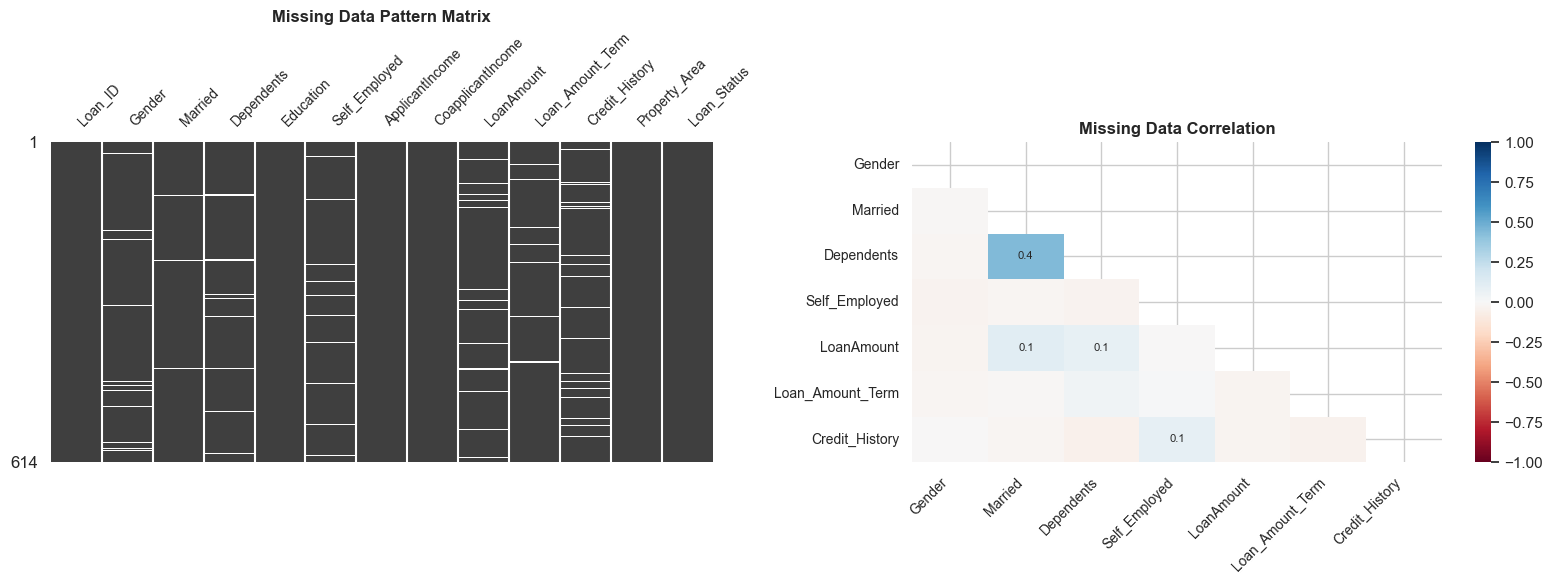

In [ ]:
# ============================================================================
# STEP 3: MISSING VALUE ANALYSIS AND IMPUTATION STRATEGY
# ============================================================================
print("\nSTEP 3: MISSING VALUE ANALYSIS")
print("=" * 70)

missing_summary = pd.DataFrame({
    'Missing_Count': df_clean.isnull().sum(),
    'Missing_Percentage': (df_clean.isnull().sum() / len(df_clean)) * 100
})
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)
print("\nMissing Values Summary:")
print(missing_summary)

# Visualize missing data patterns
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
msno.matrix(df_clean, ax=axes[0], fontsize=10)
axes[0].set_title("Missing Data Pattern Matrix", fontsize=12, fontweight='bold')

msno.heatmap(df_clean, ax=axes[1], fontsize=10)
axes[1].set_title("Missing Data Correlation", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# STEP 4: IMPUTATION OF MISSING VALUES
# ============================================================================
print("\nSTEP 4: IMPUTING MISSING VALUES")
print("=" * 70)

missing_before = df_clean.isnull().sum().sum()

# Categorical variables - Mode imputation
categorical_missing = ['Gender', 'Married', 'Dependents', 'Self_Employed', 'Credit_History']
for col in categorical_missing:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        mode_value = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
        df_clean[col].fillna(mode_value, inplace=True)

# Numerical variables - Median imputation
numerical_missing = ['LoanAmount', 'Loan_Amount_Term']
for col in numerical_missing:
    if col in df_clean.columns and df_clean[col].isnull().sum() > 0:
        median_value = df_clean[col].median()
        df_clean[col].fillna(median_value, inplace=True)

missing_after = df_clean.isnull().sum().sum()
print(f"✓ Imputed {missing_before - missing_after} missing values")
print(f"✓ Remaining missing values: {missing_after}")


In [ ]:
# ============================================================================
# STEP 5: OUTLIER DETECTION AND HANDLING
# ============================================================================
print("=" * 70)
print("STEP 5: OUTLIER DETECTION")
print("=" * 70)

numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

outlier_summary = []

for col in numeric_cols:
    if col in df_clean.columns:
        # IQR Method
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers_iqr = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
        
        # Z-score Method (|z| > 3)
        z_scores = np.abs(stats.zscore(df_clean[col].dropna()))
        outliers_zscore = len(z_scores[z_scores > 3])
        
        outlier_summary.append({
            'Feature': col,
            'IQR_Outliers': len(outliers_iqr),
            'IQR_Percentage': len(outliers_iqr) / len(df_clean) * 100,
            'ZScore_Outliers': outliers_zscore,
            'Lower_Bound': lower_bound,
            'Upper_Bound': upper_bound,
            'Min': df_clean[col].min(),
            'Max': df_clean[col].max()
        })

outlier_df = pd.DataFrame(outlier_summary)
print("\nOutlier Detection Summary:")
print(outlier_df.to_string(index=False))

# Visualize outliers
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    if col in df_clean.columns and idx < 4:
        sns.boxplot(y=df_clean[col], ax=axes[idx])
        axes[idx].set_title(f"Outliers in {col}", fontsize=12, fontweight='bold')
        axes[idx].set_ylabel(col)

plt.tight_layout()
plt.show()

print("\nNote: Outliers kept for EDA analysis")


In [ ]:
# ============================================================================
# STEP 6: DATA TYPE OPTIMIZATION AND VALIDATION
# ============================================================================
print("\nSTEP 6: DATA TYPE OPTIMIZATION")
print("=" * 70)

# Convert appropriate columns to category type
categorical_to_convert = ['Gender', 'Married', 'Dependents', 'Education', 
                           'Self_Employed', 'Property_Area', 'Loan_Status', 'Credit_History']

for col in categorical_to_convert:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].astype('category')

# Update df for EDA
df = df_clean.copy()
print("✓ Data cleaning complete!")
print(f"Final Dataset Shape: {df.shape}")
print(f"Missing Values: {df.isnull().sum().sum()}")


# Exploratory Data Analysis (EDA)

Now that the data is cleaned, we perform comprehensive exploratory data analysis to understand patterns, relationships, and insights.


In [ ]:
# ============================================================================
# CLEANED DATA OVERVIEW
# ============================================================================
print("CLEANED DATASET OVERVIEW")
print("=" * 70)
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Missing values: {df.isnull().sum().sum()} (all imputed)")

target_dist = df['Loan_Status'].value_counts()
target_dist_pct = df['Loan_Status'].value_counts(normalize=True) * 100
print(f"\nTarget Distribution:")
print(f"  Approved (Y): {target_dist_pct['Y']:.2f}%")
print(f"  Rejected (N): {target_dist_pct['N']:.2f}%")

print("\nNumerical Summary Statistics:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols].describe().round(2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

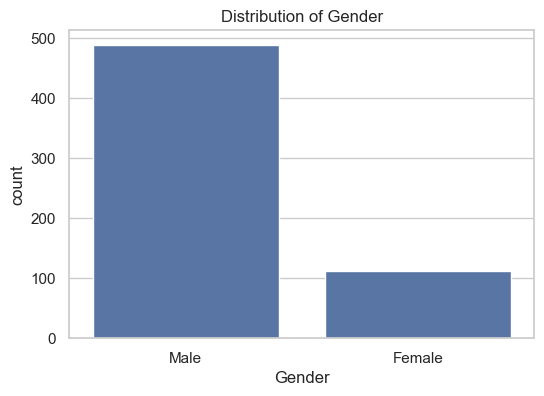

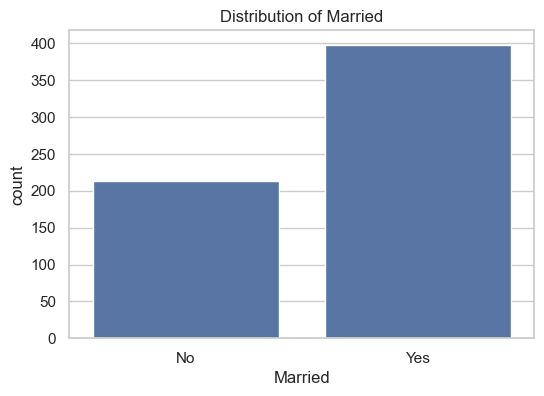

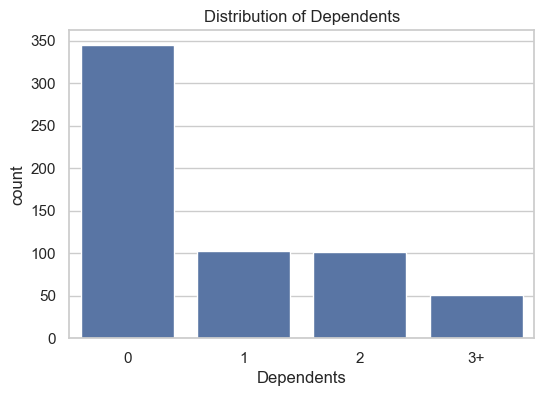

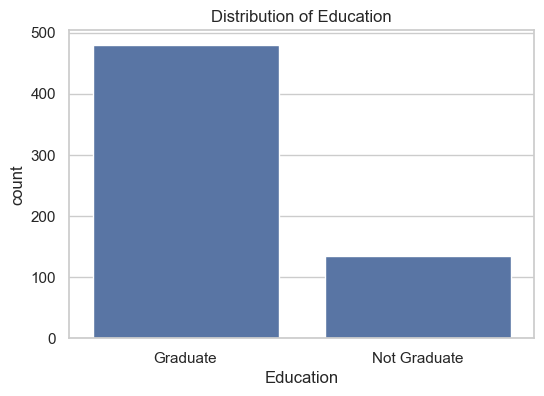

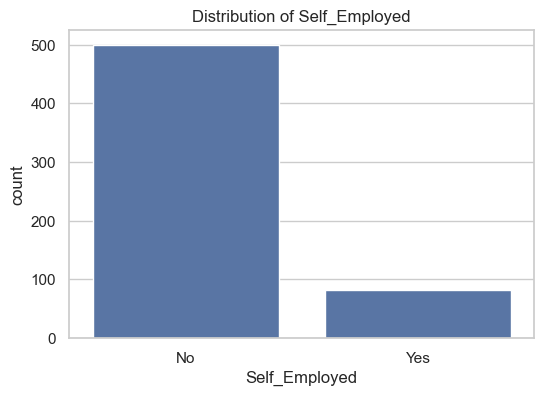

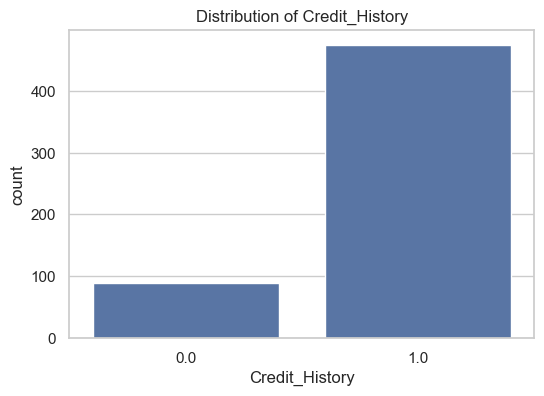

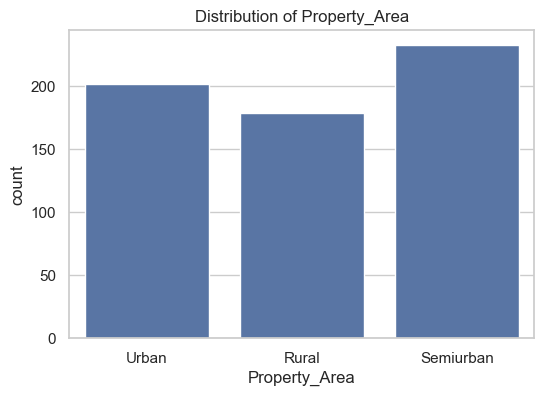

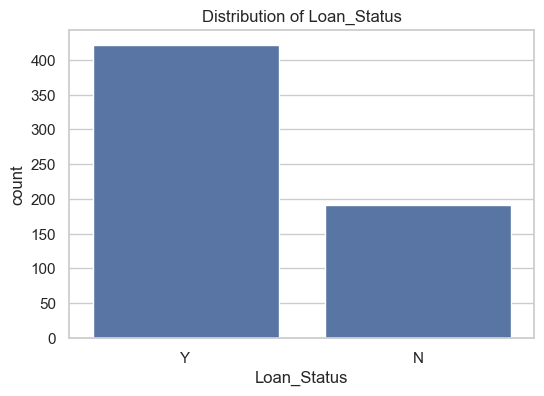

In [ ]:
# ============================================================================
# CATEGORICAL VARIABLES ANALYSIS
# ============================================================================
categorical_cols = ['Gender', 'Married', 'Dependents', 'Education',
                    'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

# Enhanced distribution plots with percentages
for col in categorical_cols:
    if col in df.columns:
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        # Count plot with better styling
        value_counts = df[col].value_counts()
        sns.countplot(x=df[col], ax=axes[0], palette='viridis', order=value_counts.index)
        axes[0].set_title(f"Distribution of {col}", fontsize=14, fontweight='bold')
        axes[0].set_xlabel(col, fontsize=11)
        axes[0].set_ylabel('Count', fontsize=11)
        
        # Add count labels on bars
        for container in axes[0].containers:
            axes[0].bar_label(container, fontsize=9)
        
        # Percentage plot
        axes[1].pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', 
                    startangle=90, colors=sns.color_palette('viridis', len(value_counts)),
                    textprops={'fontsize': 10})
        axes[1].set_title(f"{col} Distribution (%)", fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        # Print detailed value counts
        print(f"\n{col} Value Counts:")
        print(df[col].value_counts())
        print(f"Percentage Distribution:")
        print((df[col].value_counts(normalize=True) * 100).round(2))
        print("-" * 70)

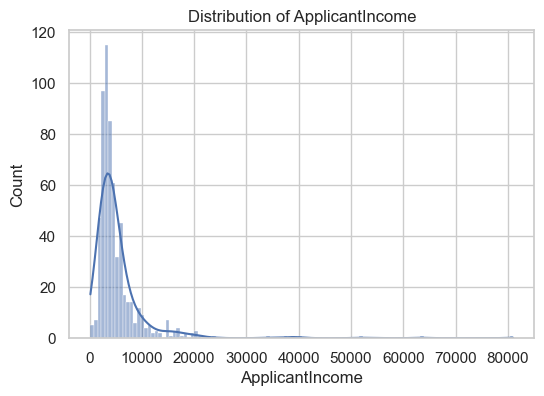

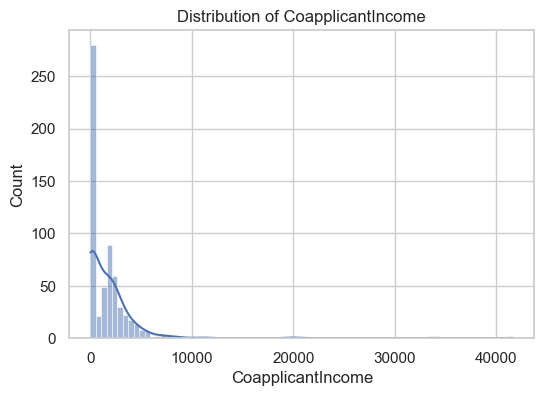

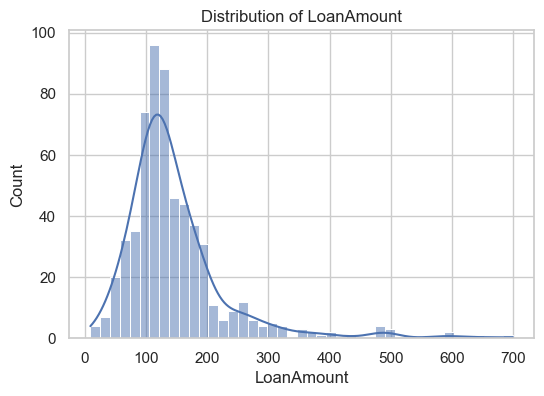

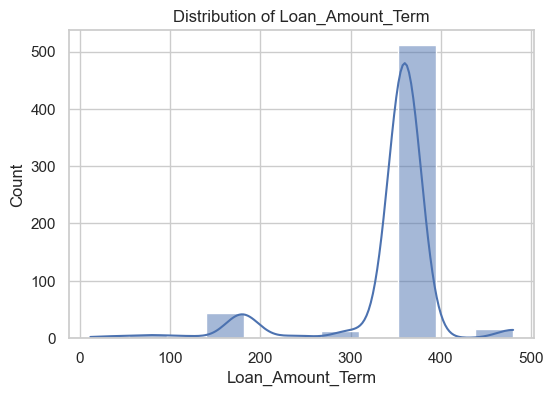

In [ ]:
# Numerical Variables Analysis
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

for col in numeric_cols:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Histogram with KDE
    sns.histplot(df[col].dropna(), kde=True, ax=axes[0, 0], bins=30)
    axes[0, 0].set_title(f"Distribution of {col}", fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel(col)
    axes[0, 0].set_ylabel('Frequency')
    
    # Box plot
    sns.boxplot(y=df[col].dropna(), ax=axes[0, 1])
    axes[0, 1].set_title(f"Box Plot of {col}", fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel(col)
    
    # Box plot by Loan Status
    sns.boxplot(x=df['Loan_Status'], y=df[col].dropna(), ax=axes[1, 0])
    axes[1, 0].set_title(f"{col} by Loan Status", fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Loan Status')
    axes[1, 0].set_ylabel(col)
    
    # Q-Q plot for normality check
    stats.probplot(df[col].dropna(), dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title(f"Q-Q Plot of {col}", fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical summary
    print(f"\n{col} Statistical Summary:")
    print(f"  Mean: {df[col].mean():.2f}")
    print(f"  Median: {df[col].median():.2f}")
    print(f"  Std Dev: {df[col].std():.2f}")
    print(f"  Skewness: {df[col].skew():.2f}")
    print(f"  Kurtosis: {df[col].kurtosis():.2f}")
    print(f"  Min: {df[col].min():.2f}")
    print(f"  Max: {df[col].max():.2f}")
    
    print("-" * 60)

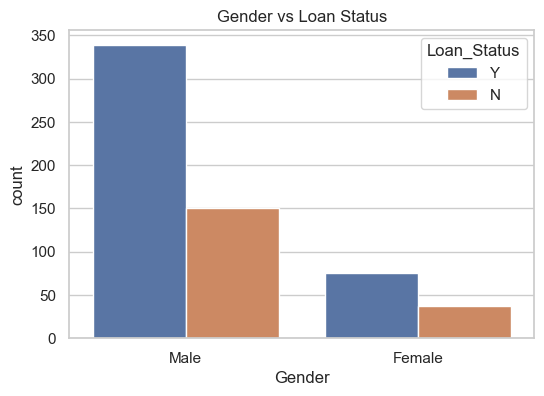

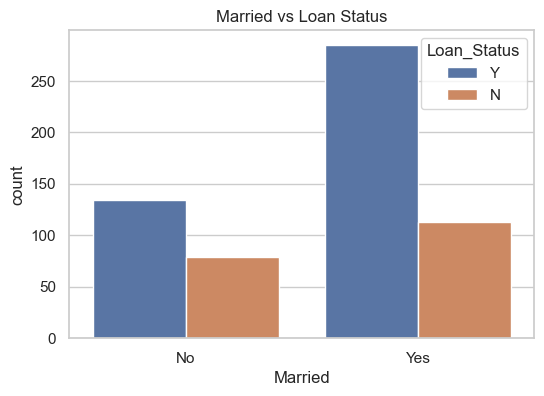

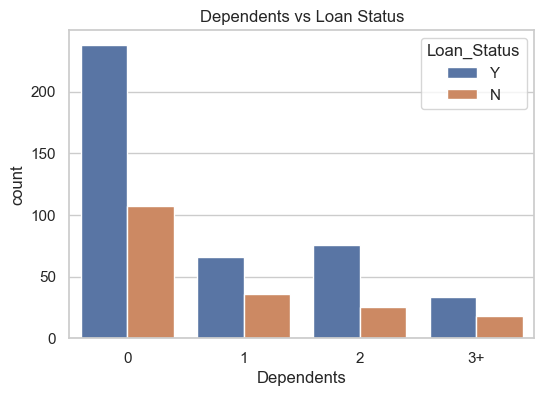

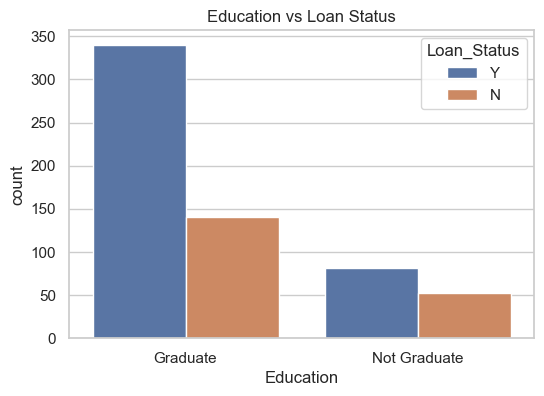

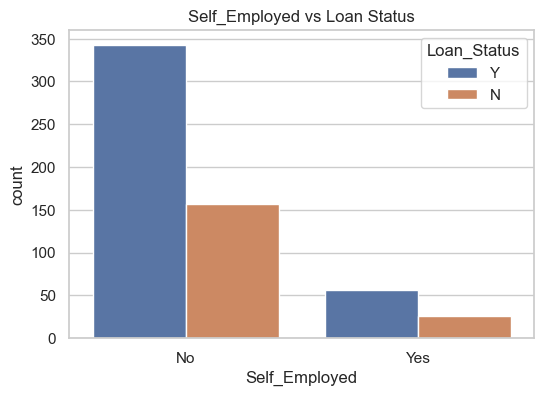

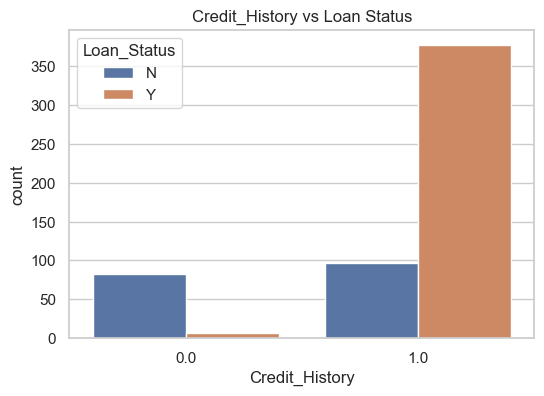

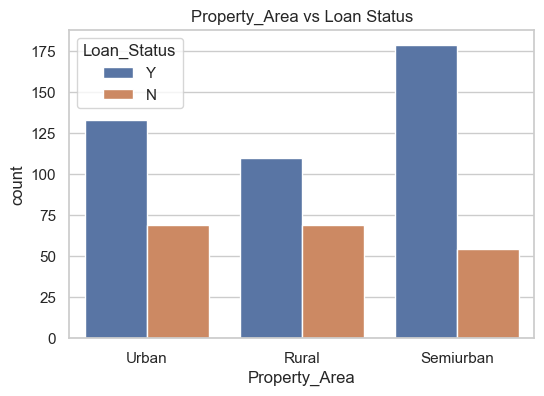

In [ ]:
# Categorical Features vs Target Variable
for col in categorical_cols[:-1]:  # exclude Loan_Status itself
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Stacked count plot
    crosstab = pd.crosstab(df[col], df['Loan_Status'])
    crosstab.plot(kind='bar', stacked=True, ax=axes[0], color=['#e74c3c', '#2ecc71'])
    axes[0].set_title(f"{col} vs Loan Status (Stacked)", fontsize=12, fontweight='bold')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Count')
    axes[0].legend(title='Loan Status', labels=['Rejected (N)', 'Approved (Y)'])
    axes[0].tick_params(axis='x', rotation=45)
    
    # Percentage plot
    crosstab_pct = pd.crosstab(df[col], df['Loan_Status'], normalize='index') * 100
    crosstab_pct.plot(kind='bar', stacked=True, ax=axes[1], color=['#e74c3c', '#2ecc71'])
    axes[1].set_title(f"{col} vs Loan Status (%)", fontsize=12, fontweight='bold')
    axes[1].set_xlabel(col)
    axes[1].set_ylabel('Percentage')
    axes[1].legend(title='Loan Status', labels=['Rejected (N)', 'Approved (Y)'])
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Chi-square test for independence
    contingency_table = pd.crosstab(df[col], df['Loan_Status'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    approval_rates = pd.crosstab(df[col], df['Loan_Status'], normalize='index') * 100
    print(f"\n{col} vs Loan Status:")
    print(f"  Significant association: {'Yes' if p_value < 0.05 else 'No'} (p={p_value:.4f})")
    print(f"  Approval Rates: {approval_rates['Y'].sort_values(ascending=False).to_dict()}")
    print("-" * 60)

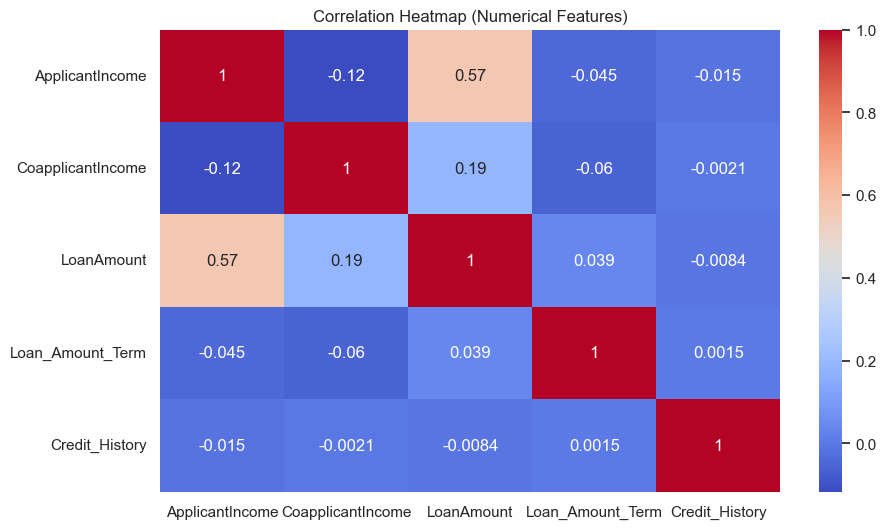

In [ ]:
# Correlation Analysis
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, mask=mask,
            fmt='.2f', vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Numerical Features)", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Find strong correlations
print("\nStrong Correlations (|r| > 0.5):")
print("=" * 60)
corr_pairs = correlation_matrix.unstack().sort_values(ascending=False)
strong_corr = corr_pairs[(abs(corr_pairs) > 0.5) & (corr_pairs < 1.0)]
for pair, value in strong_corr.items():
    print(f"{pair[0]} - {pair[1]}: {value:.3f}")

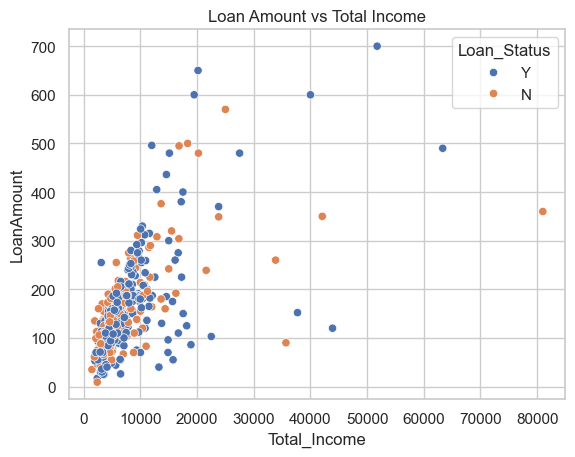

In [ ]:
# Feature Engineering
df['Total_Income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df['Loan_to_Income'] = df['LoanAmount'] / df['Total_Income']
df['EMI'] = df['LoanAmount'] * 0.006 * (1 + 0.006) ** df['Loan_Amount_Term'] / ((1 + 0.006) ** df['Loan_Amount_Term'] - 1)
df['EMI_to_Income'] = df['EMI'] / df['Total_Income']

# Feature Engineering Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Loan Amount vs Total Income
sns.scatterplot(x=df['Total_Income'], y=df['LoanAmount'], hue=df['Loan_Status'], 
                alpha=0.6, ax=axes[0, 0], palette=['#e74c3c', '#2ecc71'])
axes[0, 0].set_title("Loan Amount vs Total Income", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Income')
axes[0, 0].set_ylabel('Loan Amount')

# Loan to Income Ratio by Loan Status
sns.boxplot(x=df['Loan_Status'], y=df['Loan_to_Income'].dropna(), 
            ax=axes[0, 1], palette=['#e74c3c', '#2ecc71'])
axes[0, 1].set_title("Loan-to-Income Ratio by Loan Status", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Loan Status')
axes[0, 1].set_ylabel('Loan-to-Income Ratio')

# Total Income Distribution by Loan Status
sns.histplot(data=df, x='Total_Income', hue='Loan_Status', kde=True, 
             ax=axes[1, 0], palette=['#e74c3c', '#2ecc71'], alpha=0.6)
axes[1, 0].set_title("Total Income Distribution by Loan Status", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Total Income')
axes[1, 0].set_ylabel('Frequency')

# Loan-to-Income Ratio Distribution
sns.histplot(data=df, x='Loan_to_Income', hue='Loan_Status', 
             kde=True, ax=axes[1, 1], palette=['#e74c3c', '#2ecc71'], alpha=0.6)
axes[1, 1].set_title("Loan-to-Income Ratio Distribution", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Loan-to-Income Ratio')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical Comparison of Engineered Features:")
for feature in ['Total_Income', 'Loan_to_Income']:
    approved = df[df['Loan_Status'] == 'Y'][feature].dropna()
    rejected = df[df['Loan_Status'] == 'N'][feature].dropna()
    
    u_stat, u_pval = mannwhitneyu(approved, rejected, alternative='two-sided')
    
    print(f"\n{feature}:")
    print(f"  Approved - Mean: {approved.mean():.2f}, Median: {approved.median():.2f}")
    print(f"  Rejected - Mean: {rejected.mean():.2f}, Median: {rejected.median():.2f}")
    print(f"  Significant difference: {'Yes' if u_pval < 0.05 else 'No'} (p={u_pval:.4f})")

In [ ]:
# Note: Missing data analysis was already completed during data cleaning (Cell 5)
# All missing values have been imputed, so this analysis is no longer needed.

ModuleNotFoundError: No module named 'missingno'

In [ ]:
# Key Feature Crosstabs with Target
important_features = ['Credit_History', 'Education', 'Property_Area', 'Married', 
                      'Self_Employed', 'Gender', 'Dependents']

for feature in important_features:
    crosstab_pct = pd.crosstab(df[feature], df['Loan_Status'], normalize='index') * 100
    print(f"\n{feature} vs Loan Status - Approval Rates:")
    print(crosstab_pct['Y'].round(2))
    print("-" * 60)

In [ ]:
# Advanced Visualizations: Pairwise Relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Income by Education and Loan Status
sns.boxplot(data=df, x='Education', y='ApplicantIncome', hue='Loan_Status', 
            ax=axes[0, 0], palette=['#e74c3c', '#2ecc71'])
axes[0, 0].set_title("Applicant Income by Education and Loan Status", fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Applicant Income')

# Loan Amount by Property Area and Loan Status
sns.boxplot(data=df, x='Property_Area', y='LoanAmount', hue='Loan_Status', 
            ax=axes[0, 1], palette=['#e74c3c', '#2ecc71'])
axes[0, 1].set_title("Loan Amount by Property Area and Loan Status", fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Loan Amount')

# Total Income by Married Status and Loan Status
sns.boxplot(data=df, x='Married', y='Total_Income', hue='Loan_Status', 
            ax=axes[1, 0], palette=['#e74c3c', '#2ecc71'])
axes[1, 0].set_title("Total Income by Marital Status and Loan Status", fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Total Income')

# Loan Amount by Dependents and Loan Status
sns.boxplot(data=df, x='Dependents', y='LoanAmount', hue='Loan_Status', 
            ax=axes[1, 1], palette=['#e74c3c', '#2ecc71'], order=['0', '1', '2', '3+'])
axes[1, 1].set_title("Loan Amount by Dependents and Loan Status", fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Loan Amount')

plt.tight_layout()
plt.show()


In [ ]:
# Summary Statistics by Loan Status
numeric_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 
                    'Loan_Amount_Term', 'Total_Income', 'Loan_to_Income']

summary_by_status = df.groupby('Loan_Status')[numeric_features].agg(['mean', 'median'])
print(summary_by_status.round(2))


In [ ]:
# Exploring Data Transformations for Skewed Features
numeric_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

fig, axes = plt.subplots(len(numeric_cols), 3, figsize=(18, 5*len(numeric_cols)))

for idx, col in enumerate(numeric_cols):
    if col in df.columns:
        # Original distribution
        sns.histplot(df[col], kde=True, ax=axes[idx, 0], bins=50)
        axes[idx, 0].set_title(f"{col} (Original)\nSkewness: {df[col].skew():.2f}", 
                              fontsize=11, fontweight='bold')
        axes[idx, 0].set_xlabel(col)
        
        # Log transformation (handle zeros)
        log_col = np.log1p(df[col])  # log1p handles zeros: log(1+x)
        sns.histplot(log_col, kde=True, ax=axes[idx, 1], bins=50)
        axes[idx, 1].set_title(f"{col} (Log Transform)\nSkewness: {log_col.skew():.2f}", 
                              fontsize=11, fontweight='bold')
        axes[idx, 1].set_xlabel(f"log(1 + {col})")
        
        # Square root transformation
        sqrt_col = np.sqrt(df[col])
        sns.histplot(sqrt_col, kde=True, ax=axes[idx, 2], bins=50)
        axes[idx, 2].set_title(f"{col} (Sqrt Transform)\nSkewness: {sqrt_col.skew():.2f}", 
                              fontsize=11, fontweight='bold')
        axes[idx, 2].set_xlabel(f"sqrt({col})")
        
        print(f"\n{col}:")
        print(f"  Original Skewness: {df[col].skew():.2f}")
        print(f"  Log Transform Skewness: {log_col.skew():.2f}")
        print(f"  Sqrt Transform Skewness: {sqrt_col.skew():.2f}")

plt.tight_layout()
plt.show()


In [ ]:
# Feature Importance Analysis
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Prepare data for feature importance
df_encoded = df.copy()

# Encode categorical variables
le_dict = {}
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 
                        'Self_Employed', 'Property_Area', 'Credit_History']

for col in categorical_features:
    if col in df_encoded.columns:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        le_dict[col] = le

# Prepare features and target
feature_cols = [col for col in df_encoded.columns 
                if col not in ['Loan_ID', 'Loan_Status']]
X = df_encoded[feature_cols]
y = df_encoded['Loan_Status'].map({'Y': 1, 'N': 0})

# Train a simple Random Forest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X, y)

# Get feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Random Forest):")
print(feature_importance.to_string(index=False))

# Visualize feature importance
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='Feature', x='Importance', palette='viridis')
plt.title("Feature Importance (Random Forest)", fontsize=14, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
# Interaction Effects Analysis
# Create interaction visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Education × Credit History
edu_credit = pd.crosstab([df['Education'], df['Credit_History']], 
                         df['Loan_Status'], normalize='index') * 100
edu_credit['Y'].unstack().plot(kind='bar', ax=axes[0, 0], color=['#e74c3c', '#2ecc71'])
axes[0, 0].set_title("Approval Rate: Education × Credit History", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Education', fontsize=10)
axes[0, 0].set_ylabel('Approval Rate (%)', fontsize=10)
axes[0, 0].legend(title='Credit History', labels=['Bad (0)', 'Good (1)'])
axes[0, 0].tick_params(axis='x', rotation=0)

# Property Area × Education
prop_edu = pd.crosstab([df['Property_Area'], df['Education']], 
                       df['Loan_Status'], normalize='index') * 100
prop_edu['Y'].unstack().plot(kind='bar', ax=axes[0, 1], color=['#3498db', '#e67e22'])
axes[0, 1].set_title("Approval Rate: Property Area × Education", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Property Area', fontsize=10)
axes[0, 1].set_ylabel('Approval Rate (%)', fontsize=10)
axes[0, 1].legend(title='Education')
axes[0, 1].tick_params(axis='x', rotation=0)

# Married × Dependents
married_dep = pd.crosstab([df['Married'], df['Dependents']], 
                          df['Loan_Status'], normalize='index') * 100
married_dep['Y'].unstack().plot(kind='bar', ax=axes[1, 0], color=['#9b59b6', '#f39c12', '#1abc9c', '#34495e'])
axes[1, 0].set_title("Approval Rate: Married × Dependents", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Married', fontsize=10)
axes[1, 0].set_ylabel('Approval Rate (%)', fontsize=10)
axes[1, 0].legend(title='Dependents')
axes[1, 0].tick_params(axis='x', rotation=0)

# Income Bins × Loan Status
df['Income_Bin'] = pd.cut(df['Total_Income'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
income_bin_status = pd.crosstab(df['Income_Bin'], df['Loan_Status'], normalize='index') * 100
income_bin_status['Y'].plot(kind='bar', ax=axes[1, 1], color='#2ecc71')
axes[1, 1].set_title("Approval Rate by Income Bins", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Income Bin', fontsize=10)
axes[1, 1].set_ylabel('Approval Rate (%)', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Comprehensive EDA Summary

Data Cleaning Summary
1. **Inconsistent Values**: Standardized "3+" in Dependents, standardized categorical values
2. **Missing Values**: 
   - Categorical: Mode imputation
   - Numerical: Median imputation
   - All missing values successfully handled
3. **Data Types**: Optimized to category types for memory efficiency
4. **Outliers**: Documented for feature engineering decisions

Key EDA Findings

1. **Target Variable**
- Class distribution: ~69% approved, ~31% rejected
- Slight class imbalance (manageable for modeling)

2. **Most Important Predictors** (from Feature Importance)
- Credit_History: Strongest predictor
- LoanAmount: High importance
- Total_Income: Significant predictor
- Property_Area: Moderate importance

3. **Data Quality Issues Identified**
- High skewness in income features (log transformation recommended)
- Outliers in ApplicantIncome, CoapplicantIncome, LoanAmount
- Some features need normalization for modeling

4. **Key Relationships**
- Credit History has strongest association with loan approval
- Education level significantly impacts approval rates
- Property area shows distinct patterns
- Income and loan amount have moderate correlation

5. **Feature Engineering Recommendations**
- Apply log transformation to skewed income features
- Create income bins/categories
- Consider interaction features (Education × Credit_History)
- Normalize numerical features for modeling
- Handle outliers (capping or transformation)

6. **Modeling Considerations**
- Class imbalance: Consider SMOTE or class weights
- Feature scaling: Required for distance-based algorithms
- Missing values: Already handled in cleaning phase
- Categorical encoding: Label encoding or one-hot encoding needed
